# Multivariable LSTM with Keras

## Introduction

For this project, I will be using an LSTM neural network in an attempt to forecast prices for a financial dataset. LSTM is short for Long Short-Term Memory, a type of neural network that uses deep learning to retain predictions, hence the 'long' in the name. This is advantageous to regular neural networks as the algorithm is able to 'remember' data from further in the past. Specifically for this project, I will be attempting to predict prices for SPY before the fundamental effects of the coronavirus lead to a steep sell-off. Particularly, I will be attempting to forecast what the SPY would have possibly looked if coronavirus had not somehow happened. 

## Fundamentals 


   The stock market has been a topic that has intrigued investors and outsiders alike for as long as it has existed. Hedge funds and banks have sunk billions into research to find 'edges' that may increase the chances of being correct from just random chance and luck. These methods usually involve running deep-learning models through stupidly-large amounts of data in an attempt to find any hidden patterns or correlations. This new but ever-increasing-in-popularity approach to the markets is classified as quantitative trading. Though ultimately the market is moved in the long-term by underlying fundamentals, the market moves fundamentally only a percentage of the time. For example, fundamental announcements that give the market new information are met by violent price action that quickly bring the market to its "fair-price." 



   This move is often so quick and violent in nature that human traders have little opportunity to participate before the move has finished. Generally, movement in the markets seen on a day-to-day basis are primarily being driven by either technical factors such as sentiment and other imbalances. Once technical analysis, the study of price action, was the king for many traders. Nowadays, funds are making their quantitative findings their core philisophy for price forecasting as the edge given by technical analysis has long been traded out. However, quantitative analysis faces many hurdles. Depending on the type of gradient descent used to train the model, many machine learning models simply return weighted averages of the training dataset. This is useful to some degree, but these moving averages are already very easy to program and are used by many traders. The area in which machine learning can generate the most insight and edge, in my opinion, is in the deep learning and black box category. Data inherently is very large and hard to comb through manually, and these algorithms can help decipher patterns not obvious to the human eye with unparalleled speed. Specifically, I will be using neural networks vs. a strict time-series ARIMA approach. 


## Importing What We Need

In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools

import warnings
warnings.filterwarnings('ignore')

## Using pickle to quickly download post-EDA Dataset

In [2]:
import pickle
favorite_color = pickle.load( open( "save.p", "rb" ) )

In [3]:
favorite_color

,UVXY,SPY,TLT,GLD
Date,,,,
2011-10-04,9.911892,-1.841706,-0.699455,1.638184
2011-10-05,8.512127,-1.800349,-0.789103,1.673835
2011-10-06,8.057823,-1.770088,-0.908134,1.745987
2011-10-07,8.022386,-1.766442,-1.001126,1.704534
2011-10-10,7.232847,-1.721779,-1.093016,1.892694
...,...,...,...,...
2020-04-09,-0.247923,1.284966,3.794479,1.642145
2020-04-13,-0.247923,1.249968,3.719079,1.773008
2020-04-14,-0.247923,1.372550,3.699950,1.877273


## Adding A Shifted Column to Train Model On

In [4]:
favorite_color['SPY(t+3)'] = favorite_color['SPY'].shift(3)

In [5]:
favorite_color

,UVXY,SPY,TLT,GLD,SPY(t+3)
Date,,,,,
2011-10-04,9.911892,-1.841706,-0.699455,1.638184,NaN
2011-10-05,8.512127,-1.800349,-0.789103,1.673835,NaN
2011-10-06,8.057823,-1.770088,-0.908134,1.745987,NaN
2011-10-07,8.022386,-1.766442,-1.001126,1.704534,-1.841706
2011-10-10,7.232847,-1.721779,-1.093016,1.892694,-1.800349
...,...,...,...,...,...
2020-04-09,-0.247923,1.284966,3.794479,1.642145,1.025472
2020-04-13,-0.247923,1.249968,3.719079,1.773008,1.100073
2020-04-14,-0.247923,1.372550,3.699950,1.877273,1.188872


In [8]:
df = favorite_color.iloc[3:]

In [9]:
df

,UVXY,SPY,TLT,GLD,SPY(t+3)
Date,,,,,
2011-10-07,8.022386,-1.766442,-1.001126,1.704534,-1.841706
2011-10-10,7.232847,-1.721779,-1.093016,1.892694,-1.800349
2011-10-11,6.943680,-1.715295,-1.101715,1.845301,-1.770088
2011-10-12,5.962073,-1.696266,-1.225325,1.915612,-1.766442
2011-10-13,5.920257,-1.701330,-1.168258,1.855062,-1.721779
...,...,...,...,...,...
2020-04-09,-0.247923,1.284966,3.794479,1.642145,1.025472
2020-04-13,-0.247923,1.249968,3.719079,1.773008,1.100073
2020-04-14,-0.247923,1.372550,3.699950,1.877273,1.188872


In [10]:
df.isna().sum()

UVXY        0
SPY         0
TLT         0
GLD         0
SPY(t+3)    0
dtype: int64

Text(0.5, 1.0, 'Correlations')

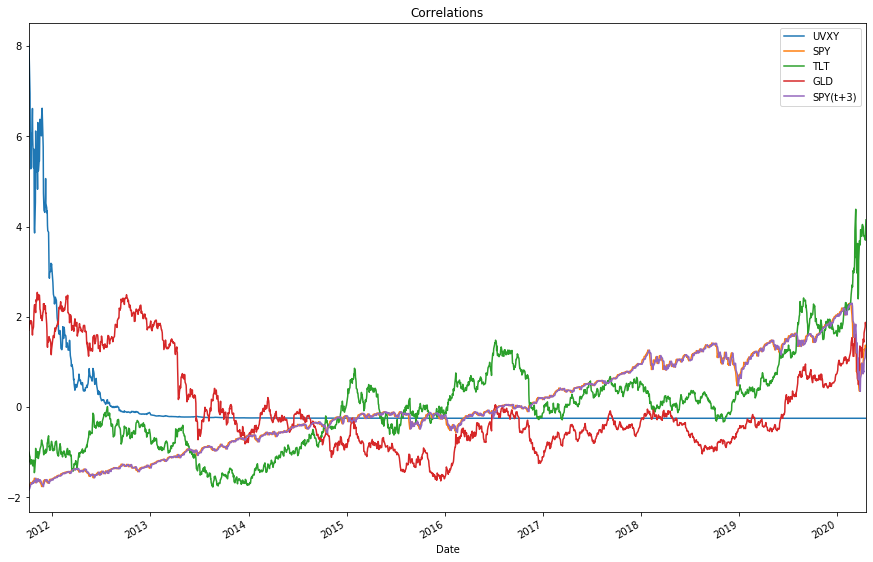

In [66]:
df.plot(figsize=(15,10))
plt.title('Correlations')

In [17]:
split_date = '2020-01-10'
train, test = df[:split_date], df[split_date:]

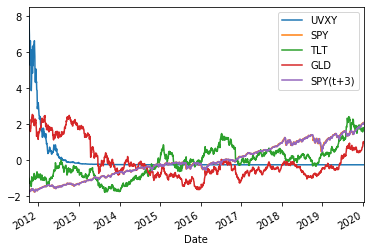

In [19]:
train.plot()

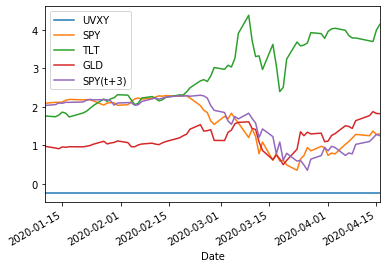

In [20]:
test.plot()

In [21]:
xtrain, ytrain = train.drop(columns = 'SPY(t+3)',inplace=False), train['SPY(t+3)']

In [22]:
xtrain

,UVXY,SPY,TLT,GLD
Date,,,,
2011-10-07,8.022386,-1.766442,-1.001126,1.704534
2011-10-10,7.232847,-1.721779,-1.093016,1.892694
2011-10-11,6.943680,-1.715295,-1.101715,1.845301
2011-10-12,5.962073,-1.696266,-1.225325,1.915612
2011-10-13,5.920257,-1.701330,-1.168258,1.855062
...,...,...,...,...
2020-01-06,-0.247925,2.038584,1.794955,1.026172
2020-01-07,-0.247925,2.037784,1.729942,1.038480
2020-01-08,-0.247925,2.059712,1.674088,1.004385


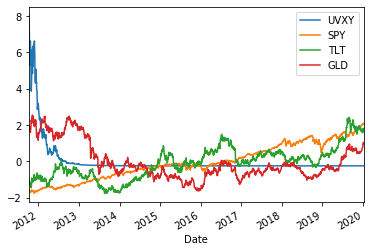

In [23]:
xtrain.plot()

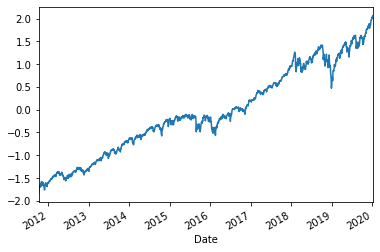

In [24]:
ytrain.plot()

In [25]:
xtest, ytest = test.drop(columns = 'SPY(t+3)',inplace=False), test['SPY(t+3)']

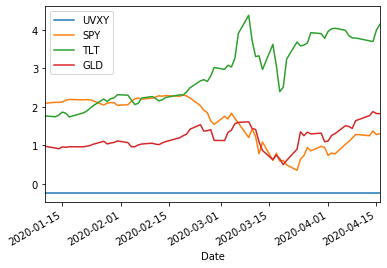

In [26]:
xtest.plot()

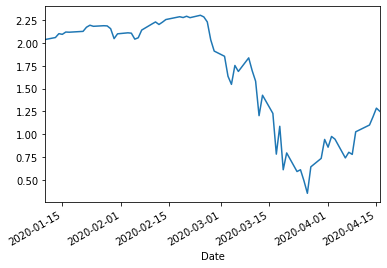

In [27]:
ytest.plot()

In [31]:
df1 = df.to_numpy()

In [32]:
df1

array([[ 8.02238583, -1.76644203, -1.00112648,  1.70453445, -1.8417055 ],
       [ 7.23284716, -1.7217787 , -1.0930163 ,  1.89269387, -1.80034906],
       [ 6.94368039, -1.71529532, -1.10171505,  1.84530058, -1.77008829],
       ...,
       [-0.24792345,  1.37254967,  3.69994983,  1.87727273,  1.18887176],
       [-0.24792324,  1.27919103,  3.99672295,  1.82888967,  1.28496618],
       [-0.24792322,  1.30350759,  4.1488239 ,  1.82407965,  1.24996756]])

In [34]:
xtest_scaled = xtest.to_numpy()

In [35]:
xtest_scaled = xtest_scaled.reshape((xtest_scaled.shape[0],1, xtest_scaled.shape[1]))

In [36]:
xtest_scaled.shape

(67, 1, 4)

In [37]:
xtrain_scaled = xtrain.to_numpy()

In [38]:
xtrain_scaled = xtrain_scaled.reshape((xtrain_scaled.shape[0],1, xtrain_scaled.shape[1]))

In [39]:
xtrain_scaled.shape

(2078, 1, 4)

In [44]:
import tensorflow as tf
from matplotlib import pyplot 
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

Using TensorFlow backend.


Train on 2078 samples, validate on 67 samples
Epoch 1/50
 - 2s - loss: 0.8507 - val_loss: 1.7056
Epoch 2/50
 - 0s - loss: 0.7943 - val_loss: 1.5954
Epoch 3/50
 - 0s - loss: 0.7445 - val_loss: 1.4812
Epoch 4/50
 - 0s - loss: 0.6944 - val_loss: 1.3647
Epoch 5/50
 - 0s - loss: 0.6425 - val_loss: 1.2466
Epoch 6/50
 - 0s - loss: 0.5866 - val_loss: 1.1251
Epoch 7/50
 - 0s - loss: 0.5249 - val_loss: 0.9955
Epoch 8/50
 - 0s - loss: 0.4561 - val_loss: 0.8594
Epoch 9/50
 - 0s - loss: 0.3799 - val_loss: 0.7353
Epoch 10/50
 - 0s - loss: 0.3034 - val_loss: 0.6291
Epoch 11/50
 - 0s - loss: 0.2524 - val_loss: 0.5551
Epoch 12/50
 - 0s - loss: 0.2292 - val_loss: 0.4960
Epoch 13/50
 - 0s - loss: 0.2038 - val_loss: 0.4380
Epoch 14/50
 - 0s - loss: 0.1765 - val_loss: 0.3809
Epoch 15/50
 - 0s - loss: 0.1518 - val_loss: 0.3380
Epoch 16/50
 - 0s - loss: 0.1339 - val_loss: 0.3098
Epoch 17/50
 - 0s - loss: 0.1228 - val_loss: 0.2883
Epoch 18/50
 - 0s - loss: 0.1123 - val_loss: 0.2648
Epoch 19/50
 - 0s - loss: 0

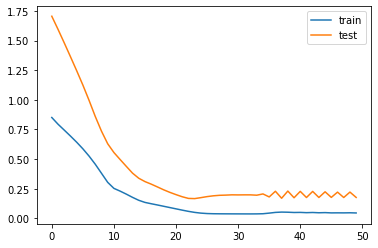

In [46]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(75, return_sequences=True))

model = Sequential()
model.add(LSTM(50, input_shape=(xtrain_scaled.shape[1], xtrain_scaled.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(xtrain_scaled, ytrain, epochs=50, batch_size=140, validation_data=(xtest_scaled, ytest), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                11000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


In [48]:
train_predict = model.predict(xtrain_scaled)
test_predict = model.predict(xtest_scaled)

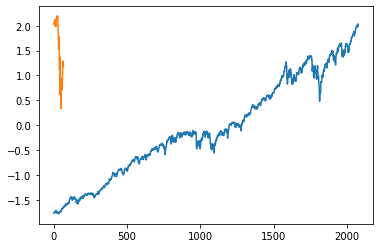

In [49]:
pyplot.plot(train_predict)
pyplot.plot(test_predict)

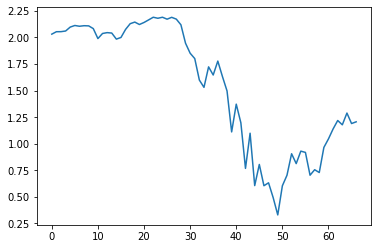

In [52]:
pyplot.plot(test_predict)



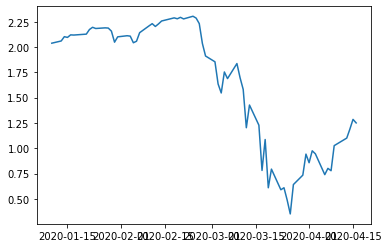

In [53]:

pyplot.plot(ytest)

In [54]:
ytest

Date
2020-01-10    2.037784
2020-01-13    2.059712
2020-01-14    2.102185
2020-01-15    2.094918
2020-01-16    2.120020
                ...   
2020-04-09    1.025472
2020-04-13    1.100073
2020-04-14    1.188872
2020-04-15    1.284966
2020-04-16    1.249968
Name: SPY(t+3), Length: 67, dtype: float64

In [55]:
ytest.values

array([2.03778431, 2.05971229, 2.10218531, 2.09491843, 2.12002015,
       2.1182345 , 2.1272967 , 2.1728564 , 2.19488018, 2.18298825,
       2.18932487, 2.18725511, 2.15691003, 2.04779982, 2.1005172 ,
       2.11143673, 2.10770841, 2.04211611, 2.05721862, 2.14169038,
       2.20914002, 2.23076626, 2.20298111, 2.22819427, 2.25711322,
       2.28799579, 2.27912137, 2.29327983, 2.27767032, 2.30407891,
       2.28586043, 2.23106495, 2.03429108, 1.91123668, 1.85396289,
       1.63491916, 1.54595486, 1.75340602, 1.68781689, 1.83657715,
       1.69694044, 1.58081832, 1.20246598, 1.42679244, 1.22759751,
       0.78038968, 1.08585912, 0.60906505, 0.79353692, 0.58960034,
       0.60923175, 0.48924654, 0.35077173, 0.64096507, 0.73375919,
       0.941667  , 0.8566019 , 0.97436396, 0.94466297, 0.73892649,
       0.80080387, 0.77757274, 1.02547228, 1.10007258, 1.18887176,
       1.28496618, 1.24996756])

No handles with labels found to put in legend.


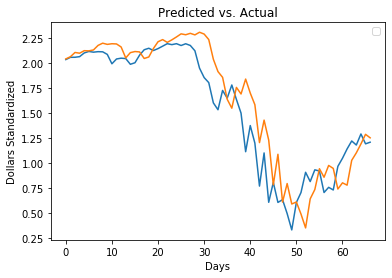

In [65]:
pyplot.plot(test_predict)
pyplot.plot(ytest.values)
plt.ylabel('Dollars Standardized')
plt.xlabel('Days')
plt.title('Predicted vs. Actual')
plt.legend()

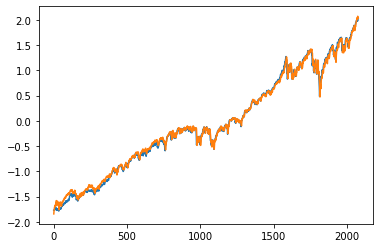

In [57]:
pyplot.plot(train_predict)
pyplot.plot(ytrain.values)

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error

In [ ]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))